In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

# Load shapefiles 

In [2]:
# kaweah shapefile
area = gp.read_file("../shape/study_area/c2vsim_sub_18.shp")
area_km2 = float(area.to_crs({'init': 'epsg:32611'}).area * 1e-6)
area.crs = {"init":"epsg:4326"}

# flowlines
flowlines = gp.read_file("../shape/plotting/C2VSimFG_StreamReaches.shp")

# Rivers
rivers = gp.read_file("../shape/plotting/streams.shp")

# Casgem wells within 
casgem = gp.read_file("../shape/plotting/casgem_wells.shp")

# Reservoirs
reservoirs = gp.read_file("../shape/study_area/res_within.shp")

# Gauges
gauges_in = gp.read_file("../shape/study_area/inflow.shp")
# gauges_out = gp.read_file("../shape/study_area/outflow.shp")

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Study Area Map

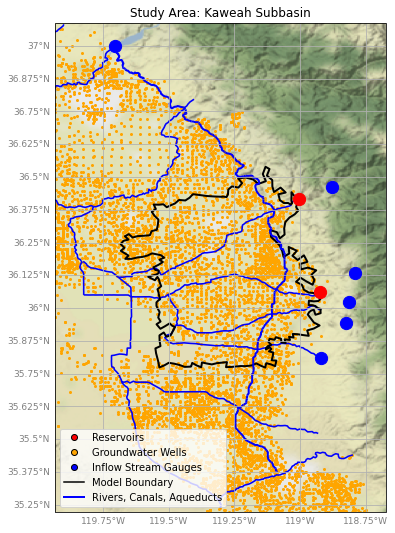

In [3]:


# Read datasets
flowlines = ShapelyFeature(Reader("../shape/plotting/streams.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 1.6)
model_boundary = ShapelyFeature(Reader('../shape/study_area/c2vsim_sub_18.shp').geometries(),
                        ccrs.PlateCarree(), edgecolor='black', facecolor = 'none', linewidth = 2)
gauges_in = ShapelyFeature(Reader("../shape/study_area/inflow.shp").geometries(),
#                         ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)
# gauges_out = ShapelyFeature(Reader("../shape/study_area/outflow.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='purple', facecolor = 'none', linewidth = 2)
fkc = ShapelyFeature(Reader("../shape/fkc_fin.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)


# Setup the figure
shapefile = "../shape/study_area/c2vsim_sub_18.shp"
plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
imextent = gp.read_file(shapefile).to_crs(4326).bounds
crs= gp.read_file(shapefile).to_crs(4326)

lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.Stamen('terrain-background')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False

gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon-.25, urlon+.25, lllat-.55, urlat+.55])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)

# Add wells
wells = list(cartopy.io.shapereader.Reader("../shape/plotting/casgem_wells.shp").geometries())
ax.scatter([point.x for point in wells],
           [point.y for point in wells],
           transform=ccrs.PlateCarree(), color = 'orange', s = 4)

# Add shapefiles
ax.add_feature(flowlines)
ax.add_feature(model_boundary)
ax.add_feature(fkc)

# Add reservoirs
reservoirs = list(cartopy.io.shapereader.Reader("../shape/study_area/res_within.shp").geometries())
ax.scatter([point.x for point in reservoirs],
           [point.y for point in reservoirs],
           transform=ccrs.PlateCarree(), color = 'red', s = 150, zorder = 1000)

# Add inflow gauges
gauges_in = list(cartopy.io.shapereader.Reader("../shape/study_area/inflow.shp").geometries())
ax.scatter([point.x for point in gauges_in],
           [point.y for point in gauges_in],
           transform=ccrs.PlateCarree(), color = 'blue', s = 150, zorder = 1000)

# Add outflow gauges
# gauges_out = list(cartopy.io.shapereader.Reader("../shape/study_area/outflow.shp").geometries())
# ax.scatter([point.x for point in gauges_out],
#            [point.y for point in gauges_out],
#            transform=ccrs.PlateCarree(), color = 'purple', s = 150, zorder = 1000)



# Setup legend
handles, labels = plt.gca().get_legend_handles_labels()

# Add legend entries
res_line = Line2D(range(0), range(0), label = 'Reservoirs', color="none", marker='o', markerfacecolor="red")
well_line = Line2D(range(0), range(0), label = 'Groundwater Wells', color="none", marker='o', markerfacecolor="orange")
in_gauge_line = Line2D(range(0), range(0), label = 'Inflow Stream Gauges', color="none", marker='o', markerfacecolor="blue")
# out_gauge_line = Line2D(range(0), range(0), label = 'Outflow Stream Gauges', color="none", marker='o', markerfacecolor="purple")
sa_line = Line2D([0], [0], label='Model Boundary ', color='black')
# shed_line = Line2D([0], [0], label='Butte County', color='black')
canals_line = Line2D([0], [0], label='Rivers, Canals, Aqueducts', color='blue', linewidth = 2)
# rivers_line = Line2D([0], [0], label='Rivers', color='blue', linewidth = 4)


# Plot legend 
handles.extend([res_line, well_line,in_gauge_line,sa_line, canals_line])
ax.legend(handles=handles, loc = 'lower left').set_zorder(99999)

# Set the title
ax.set_title("Study Area: Kaweah Subbasin", size = 12)

# Fix aspect
ax.set_aspect('auto')
plt.show()
